# 1) Primary Fuel 

In [34]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import metrics

from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.ensemble import AdaBoostClassifier

from sklearn.svm import SVC

from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline


In [35]:
df = pd.read_csv('database_IND.csv')

In [36]:
df.head()

,country,country_long,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,...,geolocation_source,wepp_id,year_of_capacity_data,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,generation_data_source,estimated_generation_gwh
0,IND,India,ACME Solar Tower,WRI1020239,2.5,28.1839,73.2407,Solar,NaN,NaN,...,National Renewable Energy Laboratory,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,IND,India,ADITYA CEMENT WORKS,WRI1019881,98.0,24.7663,74.6090,Coal,NaN,NaN,...,WRI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,IND,India,AES Saurashtra Windfarms,WRI1026669,39.2,21.9038,69.3732,Wind,NaN,NaN,...,WRI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IND,India,AGARTALA GT,IND0000001,135.0,23.8712,91.3602,Gas,NaN,NaN,...,WRI,NaN,2018.0,631.777928,617.789264,843.747,886.004428,663.774500,Central Electricity Authority,NaN
4,IND,India,AKALTARA TPP,IND0000002,1800.0,21.9603,82.4091,Coal,Oil,NaN,...,WRI,NaN,2018.0,1668.290000,3035.550000,5916.370,6243.000000,5385.579736,Central Electricity Authority,NaN


# EDA 

In [37]:
df.shape

(908, 25)

In [38]:
df.dtypes

country                      object
country_long                 object
name                         object
gppd_idnr                    object
capacity_mw                 float64
latitude                    float64
longitude                   float64
primary_fuel                 object
other_fuel1                  object
other_fuel2                  object
other_fuel3                 float64
commissioning_year          float64
owner                        object
source                       object
url                          object
geolocation_source           object
wepp_id                     float64
year_of_capacity_data       float64
generation_gwh_2013         float64
generation_gwh_2014         float64
generation_gwh_2015         float64
generation_gwh_2016         float64
generation_gwh_2017         float64
generation_data_source       object
estimated_generation_gwh    float64
dtype: object

In [39]:
df.columns

Index(['country', 'country_long', 'name', 'gppd_idnr', 'capacity_mw',
       'latitude', 'longitude', 'primary_fuel', 'other_fuel1', 'other_fuel2',
       'other_fuel3', 'commissioning_year', 'owner', 'source', 'url',
       'geolocation_source', 'wepp_id', 'year_of_capacity_data',
       'generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015',
       'generation_gwh_2016', 'generation_gwh_2017', 'generation_data_source',
       'estimated_generation_gwh'],
      dtype='object')

In [40]:
# Dropign irrielevent columsn 
df.drop(['country_long', 'name', 'gppd_idnr','latitude', 'longitude','url','geolocation_source','wepp_id','generation_data_source'],axis=1,inplace=True)

In [41]:
df.columns

Index(['country', 'capacity_mw', 'primary_fuel', 'other_fuel1', 'other_fuel2',
       'other_fuel3', 'commissioning_year', 'owner', 'source',
       'year_of_capacity_data', 'generation_gwh_2013', 'generation_gwh_2014',
       'generation_gwh_2015', 'generation_gwh_2016', 'generation_gwh_2017',
       'estimated_generation_gwh'],
      dtype='object')

In [42]:
df.shape

(908, 16)

In [43]:
df.isnull().sum()

country                       0
capacity_mw                   0
primary_fuel                  0
other_fuel1                 709
other_fuel2                 907
other_fuel3                 908
commissioning_year          380
owner                       566
source                        0
year_of_capacity_data       388
generation_gwh_2013         524
generation_gwh_2014         507
generation_gwh_2015         483
generation_gwh_2016         471
generation_gwh_2017         465
estimated_generation_gwh    908
dtype: int64

##### As we can see there is lots of column is with no value so droping all column that has larage no of outliers

In [44]:
for one_column in df.columns:
    if df[one_column].isna().sum() > 700:
        df.drop(one_column,axis=1,inplace=True)

In [45]:
df.isnull().sum()

country                    0
capacity_mw                0
primary_fuel               0
commissioning_year       380
owner                    566
source                     0
year_of_capacity_data    388
generation_gwh_2013      524
generation_gwh_2014      507
generation_gwh_2015      483
generation_gwh_2016      471
generation_gwh_2017      465
dtype: int64

In [46]:
df.dropna().shape

(0, 12)

In [50]:
# We can not drop all the null data so filling outliers

for column, dtypes in df.dtypes.items():
    if df[column].isnull().sum() > 0:
        if dtypes == 'object':
            df[column] = df[column].fillna(df[column].mode()[0])
        else:
            df[column] = df[column].fillna(df[column].mean())

In [51]:
df.isnull().sum()

country                  0
capacity_mw              0
primary_fuel             0
commissioning_year       0
owner                    0
source                   0
year_of_capacity_data    0
generation_gwh_2013      0
generation_gwh_2014      0
generation_gwh_2015      0
generation_gwh_2016      0
generation_gwh_2017      0
dtype: int64

# EDA

<AxesSubplot:>

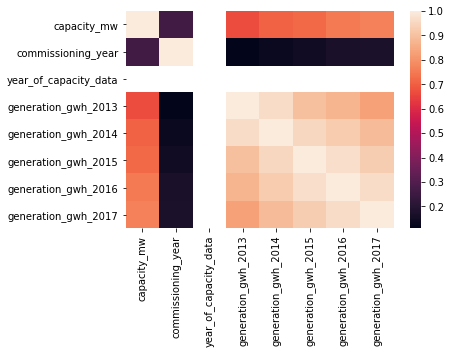

In [52]:
sns.heatmap(df.corr())

In [53]:
df.describe()

,capacity_mw,commissioning_year,year_of_capacity_data,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017
count,908.000000,908.000000,908.0,908.000000,908.000000,908.000000,908.000000,908.000000
mean,321.046378,1996.876894,2018.0,2304.059202,2420.393316,2414.072373,2453.936292,2531.754458
std,580.221767,12.994825,0.0,2465.930970,2665.360236,2860.146282,2878.730064,2923.041411
min,0.000000,1927.000000,2018.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.837500,1996.876894,2018.0,1332.538825,1175.264825,874.205000,826.629750,852.438887
50%,60.000000,1996.876894,2018.0,2304.059202,2420.393316,2414.072373,2453.936292,2531.754458
75%,388.125000,2003.000000,2018.0,2304.059202,2420.393316,2414.072373,2453.936292,2531.754458
max,4760.000000,2018.000000,2018.0,27586.200000,28127.000000,30539.000000,30015.000000,35116.000000


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                908 non-null    object 
 1   capacity_mw            908 non-null    float64
 2   primary_fuel           908 non-null    object 
 3   commissioning_year     908 non-null    float64
 4   owner                  908 non-null    object 
 5   source                 908 non-null    object 
 6   year_of_capacity_data  908 non-null    float64
 7   generation_gwh_2013    908 non-null    float64
 8   generation_gwh_2014    908 non-null    float64
 9   generation_gwh_2015    908 non-null    float64
 10  generation_gwh_2016    908 non-null    float64
 11  generation_gwh_2017    908 non-null    float64
dtypes: float64(8), object(4)
memory usage: 85.2+ KB


# Univariate Analysis

/home/aarav/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


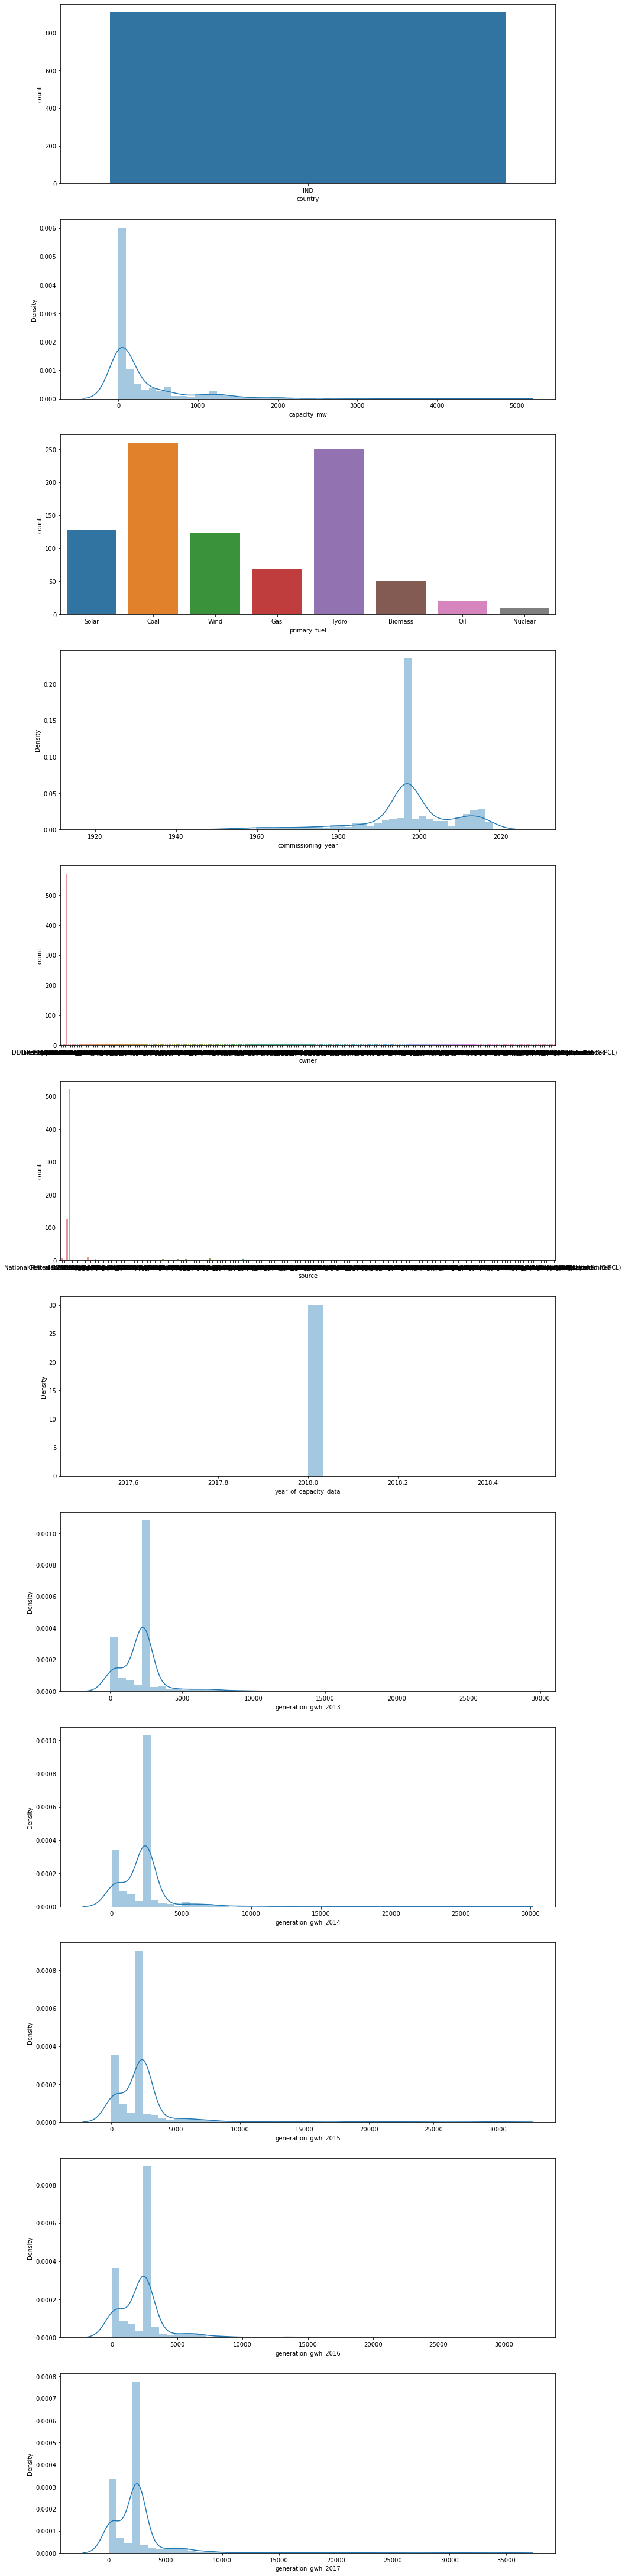

In [55]:
plt.figure(figsize=[15,200])
for i,column_data in enumerate(df.dtypes.items()):
    column, dtype  = column_data
    plt.subplot(30,1,i+1)
    
    if dtype == 'object':
        sns.countplot(df[column])
    else:
        sns.distplot(df[column],kde=True)

##### We can see that 
* Most of Powerplant running from Hyrdo or Coal
* All powerplant from IND and Year of cpacity data has only one value will drop that column

In [58]:
df['year_of_capacity_data'].value_counts()

2018.0    908
Name: year_of_capacity_data, dtype: int64

In [59]:
df.drop(['country','year_of_capacity_data'],axis=1,inplace=True)

# Bivariate Analysis

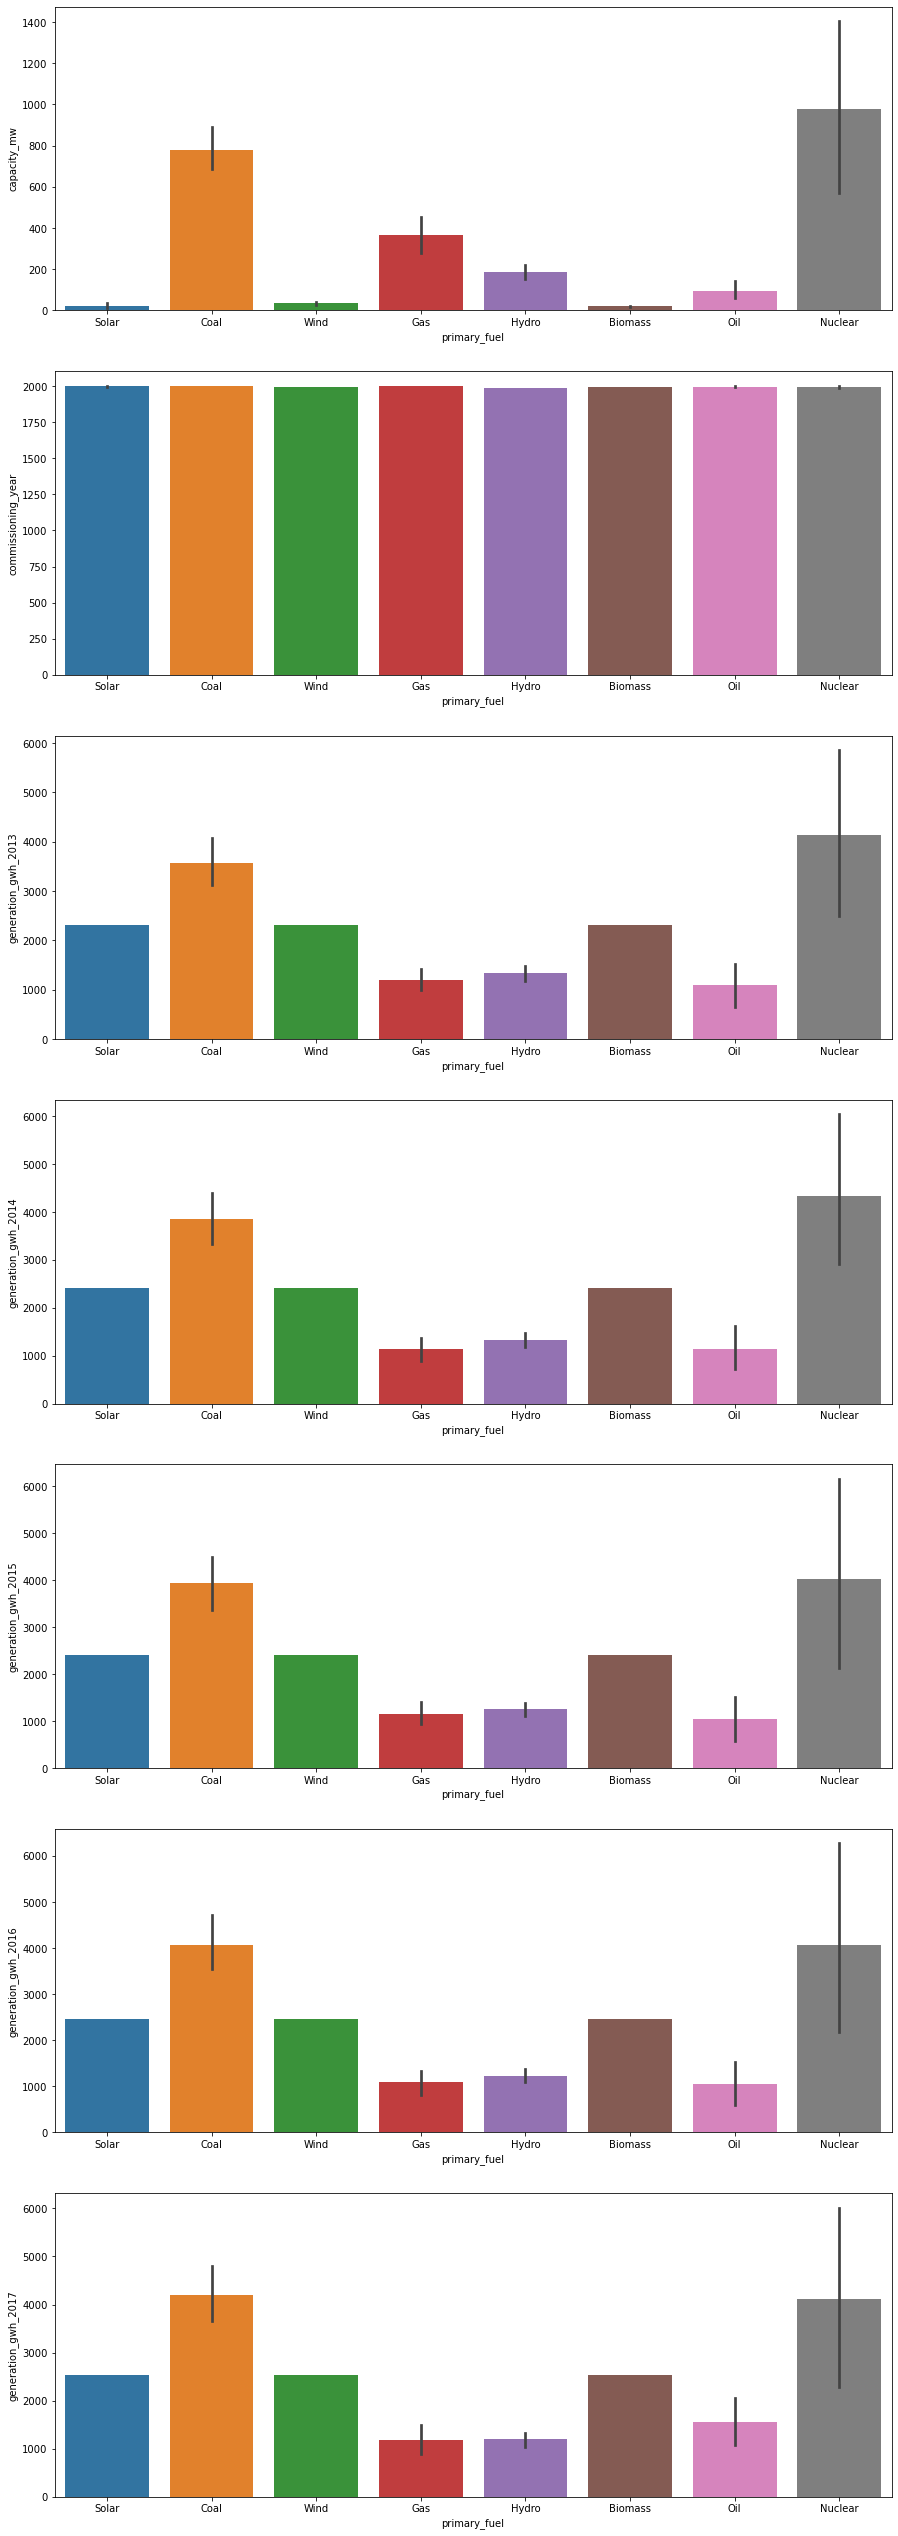

In [60]:
plt.figure(figsize=[15,200])
j = 0 
for column, dtype in df.drop('primary_fuel',axis=1).dtypes.items():
    if dtype != 'object':
        plt.subplot(30,1,j+1)    
        sns.barplot(df['primary_fuel'],df[column],)
        j += 1

##### We can see that from Graph
* Neclear and Cola is genrating more engergy then ohters
* All Fule types is comminesed in almost same year

# CHecking for outliers

In [62]:
df.columns

Index(['capacity_mw', 'primary_fuel', 'commissioning_year', 'owner', 'source',
       'generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015',
       'generation_gwh_2016', 'generation_gwh_2017'],
      dtype='object')

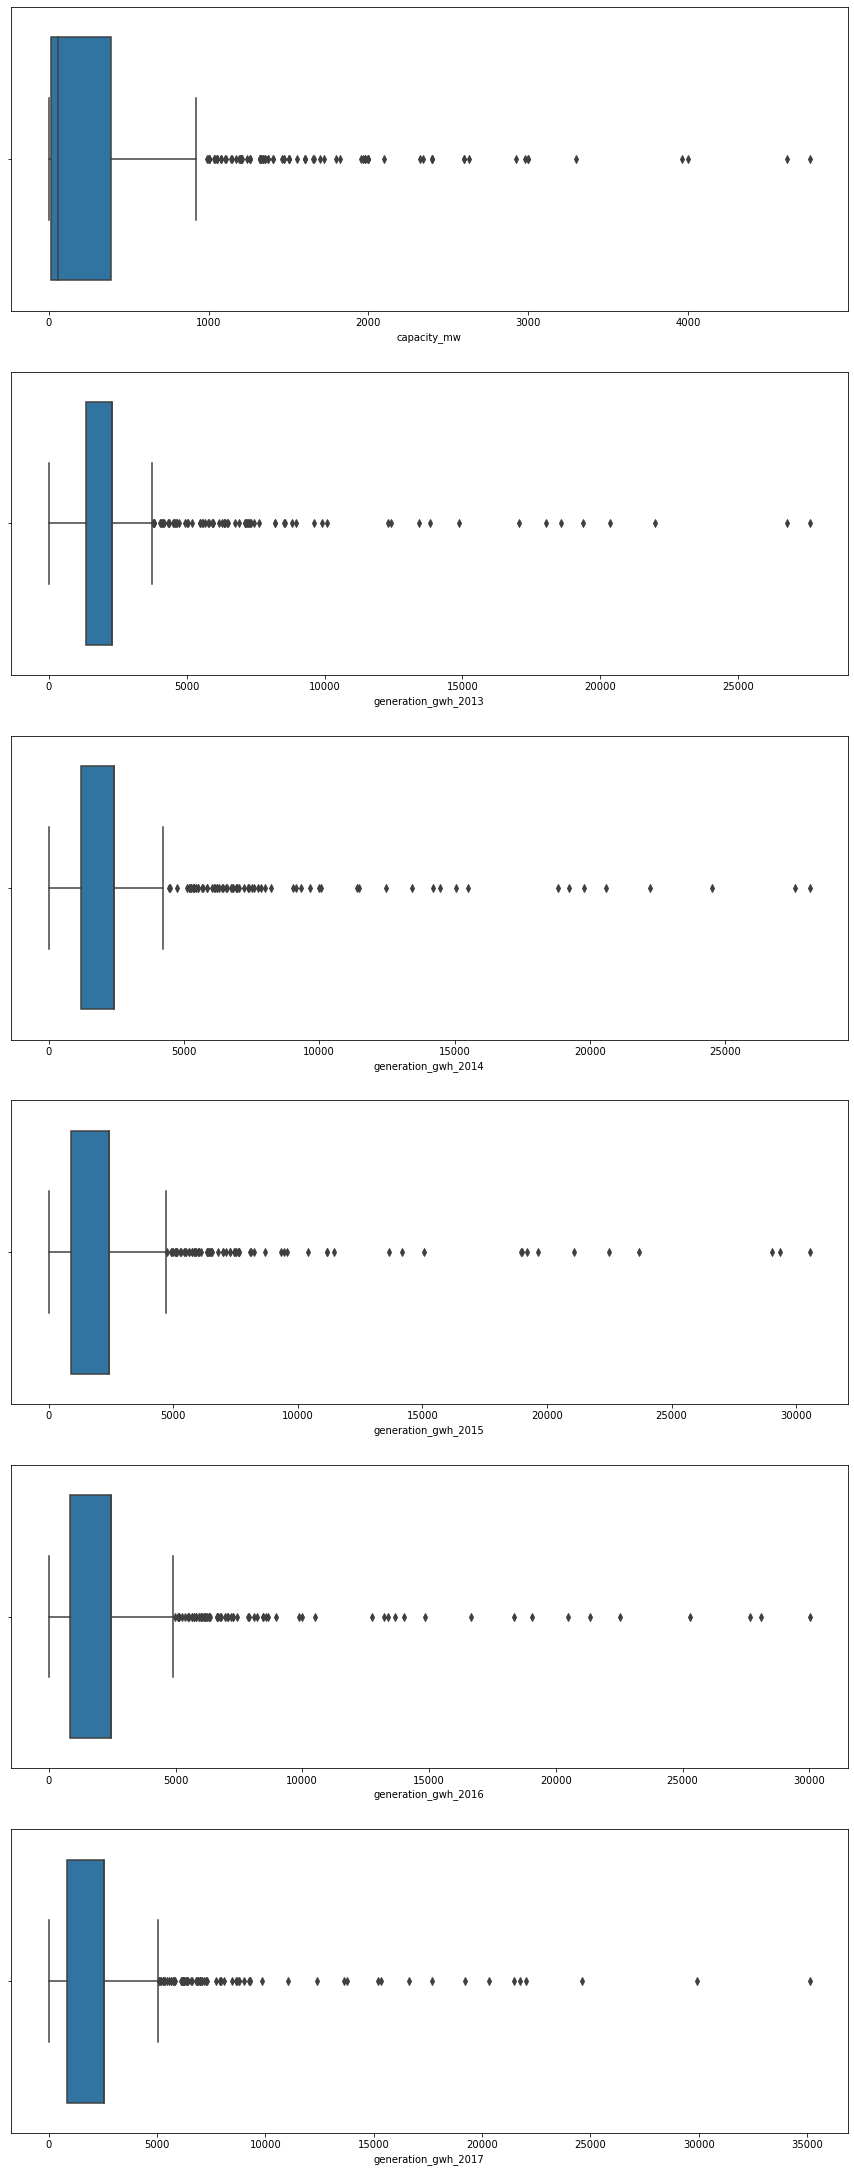

In [63]:
plt.figure(figsize=[15,200])
df_conti = df[['capacity_mw','generation_gwh_2013','generation_gwh_2014','generation_gwh_2015','generation_gwh_2016','generation_gwh_2017']]
j = 0 
for column, dtype in df_conti.dtypes.items():
    if dtype != 'object':
        plt.subplot(30,1,j+1)    
        sns.boxplot(df[column],)
        j += 1

In [66]:
df[np.abs(stats.zscore(df[['capacity_mw','generation_gwh_2013','generation_gwh_2014','generation_gwh_2015','generation_gwh_2016','generation_gwh_2017']]))> 3].index

Int64Index([ 15,  15,  15,  15, 144, 144, 144, 144, 144, 144, 159, 159, 210,
            210, 210, 210, 210, 210, 309, 309, 309, 309, 309, 309, 364, 365,
            365, 365, 365, 365, 365, 376, 483, 494, 494, 494, 494, 494, 494,
            495, 495, 495, 495, 495, 495, 533, 649, 649, 649, 649, 649, 649,
            658, 658, 658, 658, 658, 658, 696, 696, 696, 696, 696, 722, 722,
            722, 722, 725, 725, 725, 725, 725, 727, 727, 727, 727, 727, 727,
            787, 787, 787, 787, 787, 787, 789, 809, 809, 809, 809, 809, 881,
            881, 881, 881, 881, 881],
           dtype='int64')

##### As we have low data so keeping outliers 

# Doing Label Encoding

In [68]:
df = df.apply(LabelEncoder().fit_transform)

# Spliting the Data

In [69]:
X = df.drop('primary_fuel',axis=1)
y = df['primary_fuel']

In [70]:
df.skew().abs().sort_values()

capacity_mw            0.228620
primary_fuel           0.471141
generation_gwh_2017    1.018356
generation_gwh_2016    1.050854
generation_gwh_2015    1.100938
commissioning_year     1.147820
generation_gwh_2014    1.198721
generation_gwh_2013    1.302485
owner                  1.366078
source                 1.829145
dtype: float64

# Doing Power Transform

In [71]:
X_transformed = PowerTransformer().fit_transform(X)
X = pd.DataFrame(X_transformed,columns=X.columns)

# Building Model 

In [72]:
models = {
    'logisticRegression' : LogisticRegression(),
    'decisionTreeClassifier' : DecisionTreeClassifier(),
    'svc' : SVC(probability=True),
    'kNeighborsClassifier' : KNeighborsClassifier()
}

In [89]:
def build_model(model_obj):
    
    name, model = model_obj
        
    print('----------------------------------')
    print('*****',name,'******')
    print('----------------------------------')
    
    multi_class = False
    
    if len(y_train.value_counts()) > 2:
        multi_class = True
    
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy_score = metrics.accuracy_score(y_test,y_pred)
    confusion_matrix = metrics.confusion_matrix(y_test,y_pred)
    
    if not multi_class:
        y_pred_proba = model.predict_proba(X_test)[::,1]
        fpr, tpr , _ = metrics.roc_curve(y_test,y_pred_proba)
        auc = metrics.roc_auc_score(y_test,y_pred_proba)
    
        plt.figure(figsize=(5,5))
        plt.plot(fpr,tpr)
        plt.title('AUC ROC Curve for ' + name)
    
        print('auc: ',auc)
        plt.show()
    
    
    kFold = KFold(n_splits=3,shuffle=True,random_state=42)
    scores = cross_val_score(model,X,y,cv=kFold,scoring='accuracy',n_jobs=-1)
    
    mean_cv_scores = np.mean(scores)
    std_cv_scores = np.std(scores)
    
    diff_acc_score_cv_score = np.abs(accuracy_score - mean_cv_scores)
    
    print('Confussion matrix: \n',confusion_matrix)
    print('\nscore: ',accuracy_score)
    
    print('Cross Val Score: ',mean_cv_scores)
    print('Cross Val std: ',std_cv_scores)
    print('Diff Between score and CV score: ', diff_acc_score_cv_score)
    print('__________________________________________\n'*2)
    
    return (name, accuracy_score, mean_cv_scores, std_cv_scores, diff_acc_score_cv_score, model)

In [90]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,shuffle=True)

In [92]:
final_model_list = []
for one_model in models.items():
    
    name, accuracy_score, mean_cv_scores, std_cv_scores, diff_acc_score_cv_score, model = build_model(one_model)
    final_model_list.append({
        'name': name,
        'accuracy_score': accuracy_score,
        'mean_cv_scores': mean_cv_scores,
        'std_cv_scores': std_cv_scores,
        'diff_acc_score_cv_score': diff_acc_score_cv_score,
        'model': model,

    })

----------------------------------
***** logisticRegression ******
----------------------------------
Confussion matrix: 
 [[ 1  0  0  0  0  5  1]
 [ 0 51  2  8  0  6  2]
 [ 1 10  1  8  1  1  1]
 [ 0 11  0 57  0  0  0]
 [ 1  2  0  3  1  0  1]
 [ 2  1  0  1  0 17  2]
 [ 0  1  0  7  0  2 19]]

score:  0.6475770925110133
Cross Val Score:  0.6200686293794943
Cross Val std:  0.02781420806443371
Diff Between score and CV score:  0.027508463131519
__________________________________________
__________________________________________

----------------------------------
***** decisionTreeClassifier ******
----------------------------------
Confussion matrix: 
 [[ 6  0  0  0  0  0  1  0]
 [ 4 47  7  4  4  1  2  0]
 [ 2  4  9  8  0  0  0  0]
 [ 0  4  3 61  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  3  3  2  0  0  0  0]
 [ 3  4  0  0  0  0 16  0]
 [ 0  0  0  0  0  0  0 29]]

score:  0.7400881057268722
Cross Val Score:  0.7004458724018097
Cross Val std:  0.003686054589353738
Diff Between score and

# Grid search CV with best model

In [93]:
# The Best model is 
sorted(final_model_list,key=lambda item : item['diff_acc_score_cv_score'])[0]['name']

'kNeighborsClassifier'

In [95]:
kNeighborsClassifier = sorted(final_model_list,key=lambda item : item['diff_acc_score_cv_score'])[0]['model']

In [96]:
param_grid = {
    'n_neighbors': [5,6,7],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform','distance'],
    'leaf_size' : [30,40],
    
}
gridSearchCV = GridSearchCV(KNeighborsClassifier(),param_grid=param_grid,n_jobs=-1)
gridSearchCV.fit(X_train,y_train)
print(gridSearchCV.best_score_)
print(gridSearchCV.best_params_)

0.7210283383426364
{'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 7, 'weights': 'distance'}


# Saving the Model

In [98]:
pickle.dump(kNeighborsClassifier,open('kNeighborsClassifier_primary_fuel.pkl','wb'))